In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import randn, seed
from scipy.optimize import minimize

Importamos datos y nos quedamos solo con MEXBOL

In [2]:
Precios=pd.read_excel("Prueba.xlsx",index_col=0)

In [6]:
R = Precios[["MEXBOL INDEX"]]
R = np.log(R).diff().dropna()

Definimos la sigma que queremos encontrar

$$
    \sigma_t^2 = (1 - \lambda) r^2_{t-1} + \lambda \sigma_{t-1}^2
$$

Definimos la clase para Volatilidad Dinamica

In [82]:
class VolDimSigmas:
    """
    Clase para estimar sigmas para el modelo de Volatilidad Dinamica
    """
    def __init__(self, Lambda, sigma_init, R):
        self.Lambda = Lambda
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        """
        Calcula sigma_t dado datos en t - 1
        """
        rt0 = 0 if t == 0 else self.R.iloc[t - 1, 0]
        sigma0 = self.sigma_hist[-1]
        sigma1 = (1-self.Lambda)* rt0 ** 2 + self.Lambda * sigma0
        self.sigma_hist.append(sigma1)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma1(t)

Definimos la funcion LVolDim que nos regresa la log-verosimilitud de la volatilidad dinamica

In [83]:
def LVolDim(Lambda, sigma_init, R):
    s = VolDimSigmas(Lambda, sigma_init, R)
    sigma_hist = np.array(s.sigma_hist[1:]).ravel()
    r1_2 = R.values.ravel() ** 2
    log_likelihood = (np.log(sigma_hist) + r1_2 / sigma_hist).sum() / 2
    return log_likelihood

In [85]:
seed(314)
Lambda = np.abs(randn(1))
sigma_init = R.var(ddof=1).item() / 252
LVolDim(Lambda, sigma_init, R)

-1333.747975676454

In [67]:
# Configuración del modelo
x0 = np.array([Lambda])
L_part = lambda x0: LGarch(*x0, sigma_init, R)

# restricción de no negativos
bounds = [
    (0, 1)
]

In [68]:
fmin = minimize(L_part, x0,
         bounds=bounds)

In [69]:
fmin

      fun: -4355.8260787813315
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00045475])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 22
      nit: 8
   status: 0
  success: True
        x: array([0.9088626])

In [72]:
Lambda_VD=fmin.x
Lambda_VD

array([0.9088626])

In [77]:
# Volatilidades sigma2
sigma0 = sigma_init
garch_predict = []
for i in range(len(R)):
    sigma0 = float((1-Lambda_VD)* R.iloc[i].item() ** 2 + Lambda_VD* sigma0)
    garch_predict.append(sigma0)

C:\Users\mariana.naude\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


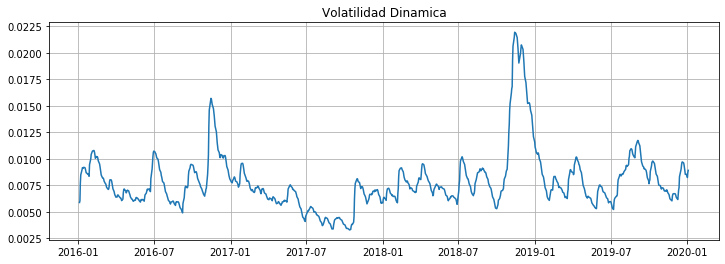

In [80]:
xaxis = R.index[1:]
sigma_garch = pd.Series(np.sqrt(garch_predict)[1:])

plt.subplots(figsize=(12, 4))
plt.title("Volatilidad Dinamica")
plt.grid()
plt.plot(xaxis, sigma_garch.ewm(2).mean());